In [1]:
#%matplotlib notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

from scipy import integrate

import os
import os.path as path
import wget

from tqdm import tqdm
import corner

In [2]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [3]:
np.mean(sample)

0.9484999999999999

In [4]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size=len(sample), replace=True )
    return resample_
    

In [5]:
np.mean(Resample(sample))

0.9836

In [6]:
def Bootstrapping(sample, N = int(1e5)):
    
    Mean_Dist = np.zeros( N )
    
    for i in tqdm(range(N)):
        resample_ = Resample(sample)
        Mean_Dist[i] = np.mean(resample_)
        
    return Mean_Dist

In [7]:
Mean_Dist = Bootstrapping(sample)

100%|████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10657.80it/s]


In [22]:
# Parametros de la distribucion
N = len(Mean_Dist)
xbar = np.mean(sample)
#xbar = np.percentile(Mean_Dist,50)
std = np.std(Mean_Dist)
print(xbar,std)

0.9484999999999999 0.02378585056572575


In [23]:
def Gaussian(x,mu,sigma): # Luego será el Likelihood
    
    return np.exp( -(x-mu)**2/(2*sigma**2) )/np.sqrt(2*np.pi*sigma**2)

In [24]:
x = np.linspace(np.min(sample),np.max(sample),100)
y = Gaussian(x,xbar,std)

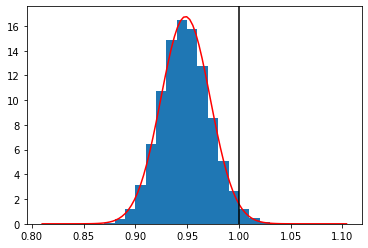

In [25]:
plt.hist(Mean_Dist,bins=np.arange(np.min(sample),np.max(sample),0.01),density=True)
plt.plot(x,y,color='r')
plt.axvline(x=1,color='k')

In [12]:
#probabilidad de obtener usando el modelo de probabilidad
I = integrate.quad(Gaussian,1.,np.inf,args=(xbar,std))[0]
print(I)

0.015187994334378025


In [13]:
# Usando los datos los eventos donde la media es igual o mayor a 1.
datasort = np.sort(Mean_Dist)

ii = np.where( datasort >= 1. )

EventosFavorables = np.sum( datasort[ii] )

frecuencia_relativa = EventosFavorables/N
print(frecuencia_relativa)

0.018519257


In [29]:
if not path.exists('Data'):
    os.mkdir('Data')
    
file = 'Data/Minimos.dat' 

#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
else:
    Path_ = file

100% [..................................................................................] 521 / 521

In [30]:
data = np.loadtxt(Path_)
x = data[:,0]
y = data[:,1]
N = len(x)
sigma = np.random.uniform(0,0.2,N)
sigma
print(N)

20


<ErrorbarContainer object of 3 artists>

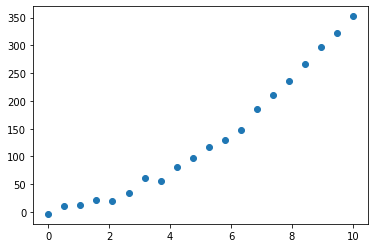

In [31]:
plt.errorbar(x,y,yerr=sigma,fmt='o')

In [32]:
def GetFit(x,y,n=2):
    
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)
    
    xsol = np.linalg.solve(AT,bT)
    
    return xsol

In [34]:
n = 2
param = GetFit(x,y,n)
param

array([1.22132054, 6.09075205, 2.9565874 ])

In [35]:
def GetModel(x,p):
    
    y = 0
    for n in range(len(p)):
        y += p[n]*x**n
        
    return y

In [36]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.95658740177385*x**2 + 6.0907520463624*x + 1.2213205361703

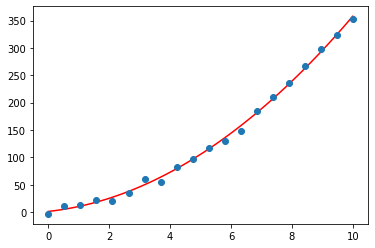

In [37]:
_x = np.linspace(np.min(x),np.max(x),50)

_y = GetModel(_x,param)

plt.errorbar(x,y,yerr=sigma,fmt='o')
plt.plot(_x,_y,color='r')

# Bootstrapping (Bradley Efron 1979)

In [38]:
dict1 = dict(zip(x,y))
dict1

{0.0: -3.348886,
 0.5263158: 10.779,
 1.052632: 13.12721,
 1.578947: 21.20879,
 2.105263: 20.63223,
 2.631579: 34.11089,
 3.157895: 60.66644,
 3.684211: 55.07888,
 4.210526: 81.89598,
 4.736842: 96.83438,
 5.263158: 117.5549,
 5.789474: 130.5394,
 6.315789: 147.7079,
 6.842105: 185.1728,
 7.368421: 210.7779,
 7.894737: 235.0856,
 8.421053: 266.336,
 8.947368: 297.0943,
 9.473684: 322.7923,
 10.0: 352.3838}

In [46]:
def GetBootstrapping(x,n=2,NTrials=int(3e4)):
    
    Values = np.zeros((NTrials,n+1))
    
    #print(Values)
    
    for i in tqdm(range(NTrials)):
        
        x1 = Resample(x)
        
        y1 = np.array([])
        for j in x1:
            y1 = np.append(y1,dict1[j])
            
        p = GetFit(x1,y1,n)
        
        Values[i] = p
        
    return Values

In [ ]:
Mean_Dist = GetBootstrapping(x)

 67%|████████████████████████████████████▋                  | 20027/30000 [00:11<00:05, 1717.50it/s]